# 06 — Cluster metrics & heuristic labels

En esta notebook:
1) Cargamos los puntos clusterizados y limpios (`veg_gt2m_dbscan_clean.csv`).
2) Calculamos métricas por *ClusterID* (alturas pXX, bbox, densidad).
3) Etiquetamos cada cluster con reglas heurísticas por p95 de altura.
4) Exportamos:
   - `data/processed/cluster_metrics.csv`
   - `data/processed/veg_gt2m_labeled_points.csv`
5) Gráficos rápidos para sanity check.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Reglas heurísticas por p95 (metros)
LABEL_RULES = [
    ("arbusto",       0,    5),
    ("árbol_bajo",    5,   12),
    ("árbol_medio",  12,   25),
    ("árbol_alto",   25, 1e9),
]

ROOT = Path(".")
DATA = ROOT / "data"
PROC = DATA / "processed"

IN_POINTS = PROC / "veg_gt2m_dbscan_clean.csv"
OUT_CLUSTER_METRICS = PROC / "cluster_metrics.csv"
OUT_POINTS_LABELED  = PROC / "veg_gt2m_labeled_points.csv"

assert IN_POINTS.exists(), f"No encuentro {IN_POINTS}. Corré 04_dbscan y 05_exploration antes."

usecols = ["X","Y","HeightAboveGround","ClusterID"]
dtypes  = {"X":"float32","Y":"float32","HeightAboveGround":"float32","ClusterID":"int32"}

df = pd.read_csv(IN_POINTS, usecols=usecols, dtype=dtypes)
print(f"Puntos: {len(df):,} | Clusters: {df['ClusterID'].nunique():,}")
df.head()

Puntos: 121,017 | Clusters: 3,552


,X,Y,HeightAboveGround,ClusterID
0,1843210.750,5444999.0,31.340000,0
1,1843210.625,5444999.5,33.720001,0
2,1843210.750,5444999.0,32.060001,0
3,1843210.875,5444999.0,32.139999,0
4,1843211.000,5444999.0,32.070000,0


In [2]:
# Alturas
agg = df.groupby("ClusterID")["HeightAboveGround"].agg(
    n="count",
    h_min="min",
    h_q25=lambda s: s.quantile(0.25),
    h_med="median",
    h_mean="mean",
    h_q75=lambda s: s.quantile(0.75),
    h_p95=lambda s: s.quantile(0.95),
    h_max="max",
).reset_index()

# XY bbox + centroides
xy = df.groupby("ClusterID").agg(
    x_min=("X","min"), x_max=("X","max"),
    y_min=("Y","min"), y_max=("Y","max"),
    cx=("X","mean"),  cy=("Y","mean"),
).reset_index()

xy["dx"] = (xy["x_max"] - xy["x_min"]).astype("float32")
xy["dy"] = (xy["y_max"] - xy["y_min"]).astype("float32")
xy["area_bbox_m2"] = (xy["dx"] * xy["dy"]).astype("float32")

# Unir y densidad
metrics = agg.merge(xy, on="ClusterID", how="left")
metrics["pt_density"] = metrics["n"] / metrics["area_bbox_m2"].replace({0: np.nan})
metrics["pt_density"] = metrics["pt_density"].fillna(0).astype("float32")

# Orden útil
metrics = metrics.sort_values("n", ascending=False).reset_index(drop=True)
metrics.head(10)

,ClusterID,n,h_min,h_q25,h_med,h_mean,h_q75,h_p95,h_max,x_min,x_max,y_min,y_max,cx,cy,dx,dy,area_bbox_m2,pt_density
0,567,610,6.134,9.44525,10.2800,10.152450,11.08625,12.17215,12.986000,1843623.000,1843628.750,5444985.0,5444994.5,1843625.750,5444990.0,5.750,9.5,54.6250,11.167048
1,1343,545,8.821,10.70200,12.6600,12.533252,14.11700,15.80800,16.740000,1843985.250,1843993.250,5444917.0,5444927.5,1843989.125,5444922.0,8.000,10.5,84.0000,6.488095
2,684,470,8.504,10.63000,11.1400,11.503287,11.63450,15.15000,15.700000,1843560.875,1843567.250,5444896.0,5444903.5,1843564.250,5444899.5,6.375,7.5,47.8125,9.830066
3,673,429,8.070,9.68000,10.1800,10.564045,11.06600,14.61000,16.559999,1843570.125,1843576.250,5444906.5,5444914.5,1843573.375,5444910.5,6.125,8.0,49.0000,8.755102
4,2738,388,7.580,9.05000,9.6650,9.700457,10.44250,11.07800,11.467000,1843526.000,1843532.625,5444236.5,5444243.5,1843529.625,5444240.0,6.625,7.0,46.3750,8.366577
5,3509,362,6.930,8.40250,9.0200,9.032000,9.54000,10.77950,10.990000,1843788.375,1843794.250,5444024.0,5444030.0,1843791.000,5444027.0,5.875,6.0,35.2500,10.269504
6,742,352,8.684,10.14100,10.8720,10.711480,11.32700,11.88560,12.203000,1843531.250,1843536.625,5444857.0,5444862.0,1843534.125,5444859.5,5.375,5.0,26.8750,13.097674
7,710,307,10.808,11.79850,12.5800,12.601623,13.46150,14.18680,14.430000,1843546.625,1843551.000,5444881.5,5444887.0,1843549.000,5444884.0,4.375,5.5,24.0625,12.758442
8,661,292,9.860,11.21000,11.6025,11.593901,12.05000,12.56450,14.106000,1843577.750,1843584.250,5444916.0,5444921.0,1843580.875,5444918.5,6.500,5.0,32.5000,8.984615
9,2428,292,7.490,9.85750,11.1465,10.664021,11.48250,11.76450,11.950000,1843655.000,1843662.375,5444423.0,5444427.5,1843658.750,5444425.0,7.375,4.5,33.1875,8.798493


In [3]:
def assign_label(h: float, rules=LABEL_RULES) -> str:
    for name, lo, hi in rules:
        if lo <= h < hi:
            return name
    return "sin_label"

# 1) etiqueta base por p95
metrics["label_v1"] = metrics["h_p95"].apply(assign_label)

# 2) si es bajo y MUY denso → "matorral/arbusto"
DENSE_THRESH = 0.08  # pts/m² (ajústalo según tu nube)
mask = (metrics["label_v1"] == "arbusto") & (metrics["pt_density"] > DENSE_THRESH)
metrics.loc[mask, "label_v1"] = "matorral/arbusto"

# 3) etiqueta final
metrics["label"] = metrics["label_v1"]

metrics[["ClusterID","n","h_p95","h_mean","h_max","area_bbox_m2","pt_density","label"]].head(12)

,ClusterID,n,h_p95,h_mean,h_max,area_bbox_m2,pt_density,label
0,567,610,12.17215,10.152450,12.986000,54.6250,11.167048,árbol_medio
1,1343,545,15.80800,12.533252,16.740000,84.0000,6.488095,árbol_medio
2,684,470,15.15000,11.503287,15.700000,47.8125,9.830066,árbol_medio
3,673,429,14.61000,10.564045,16.559999,49.0000,8.755102,árbol_medio
4,2738,388,11.07800,9.700457,11.467000,46.3750,8.366577,árbol_bajo
5,3509,362,10.77950,9.032000,10.990000,35.2500,10.269504,árbol_bajo
6,742,352,11.88560,10.711480,12.203000,26.8750,13.097674,árbol_bajo
7,710,307,14.18680,12.601623,14.430000,24.0625,12.758442,árbol_medio
8,661,292,12.56450,11.593901,14.106000,32.5000,8.984615,árbol_medio
9,2428,292,11.76450,10.664021,11.950000,33.1875,8.798493,árbol_bajo


In [4]:
# Guardar métricas
metrics.to_csv(OUT_CLUSTER_METRICS, index=False)

# Unir etiquetas a cada punto
df_labels = metrics[["ClusterID","label"]]
df_labeled = df.merge(df_labels, on="ClusterID", how="left")
df_labeled.to_csv(OUT_POINTS_LABELED, index=False)

print("✔ Guardado:", OUT_CLUSTER_METRICS)
print("✔ Guardado:", OUT_POINTS_LABELED)
df_labeled.head()

✔ Guardado: data/processed/cluster_metrics.csv
✔ Guardado: data/processed/veg_gt2m_labeled_points.csv


,X,Y,HeightAboveGround,ClusterID,label
0,1843210.750,5444999.0,31.340000,0,árbol_alto
1,1843210.625,5444999.5,33.720001,0,árbol_alto
2,1843210.750,5444999.0,32.060001,0,árbol_alto
3,1843210.875,5444999.0,32.139999,0,árbol_alto
4,1843211.000,5444999.0,32.070000,0,árbol_alto


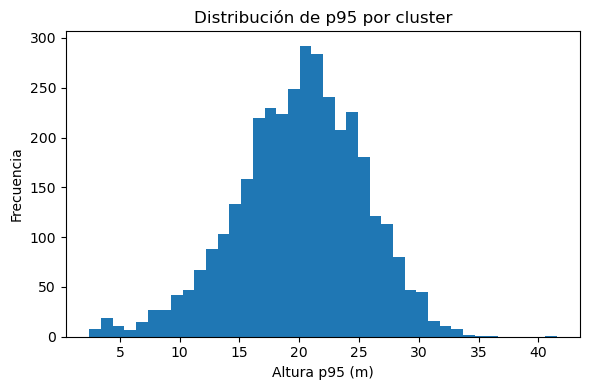

label
árbol_medio         2686
árbol_alto           610
árbol_bajo           220
matorral/arbusto      36
Name: count, dtype: int64


In [5]:
plt.figure(figsize=(6,4))
plt.hist(metrics["h_p95"], bins=40)
plt.xlabel("Altura p95 (m)")
plt.ylabel("Frecuencia")
plt.title("Distribución de p95 por cluster")
plt.tight_layout()
plt.show()

# Conteo por etiqueta
print(metrics["label"].value_counts())